# Import

In [1]:
import logging
# Logging Configuration
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.info("Logging initialized. Starting script execution.")


import pandas as pd
import numpy as np
import shap
import os
import optuna
import matplotlib.pyplot as plt
# display Matplotlib plots directly within the notebook interface
%matplotlib inline 

import torch
import torch.nn as nn  # neural network
import torch.nn.functional as F  # Move data forward in function
import torch.optim as optim
import ray

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from torch.utils.data import TensorDataset, DataLoader
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

from optuna.visualization import plot_optimization_history, plot_param_importances

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from torch.utils.data import DataLoader, TensorDataset


from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.hyperopt import HyperOptSearch
from ray.air import session

2024-12-06 21:51:31,623 - INFO - Logging initialized. Starting script execution.


# Dataframes

In [2]:
"""
We convert the data into float32 because PyTorch expects float 32 values
- Compatibility with DL
- Memory Efficiency
- Prevent errors in training (backpropagation etc)
"""
# Data Loading and Conversion to float32
logger.info("Starting to load datasets...")

# Define subfolder
subfolder = "o6_GAN/o02"

try:
    # Load CSV files and convert to float32 for compatibility
    X_external = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/X_external.csv").astype('float32')
    y_external = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/y_external.csv").values.ravel().astype('float32')
    X_train = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/X_train.csv").astype('float32')
    y_train = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/y_train.csv").values.ravel().astype('float32')
    X_validate = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/X_validate.csv").astype('float32')
    y_validate = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/y_validate.csv").values.ravel().astype('float32')
    X_test = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/X_test.csv").astype('float32')
    y_test = pd.read_csv(f"../03_External_Validation/CSV/exports/impute/{subfolder}/y_test.csv").values.ravel().astype('float32')
    
    logger.info("Datasets loaded and converted to float32 successfully.")
except Exception as e:
    logger.error(f"Error occurred while loading datasets: {e}")
    raise

2024-12-06 21:51:35,918 - INFO - Starting to load datasets...
2024-12-06 21:51:40,718 - INFO - Datasets loaded and converted to float32 successfully.


In [4]:
"""
All computations in PyTorch are performed by the use of tensors
and not with pandas dataframes or NymPy arrays.

X_train.values extract NumPy arrays from pandas dataframe
and torch.tensor converts it to PyTorch tensor.
"""

logger.info(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
logger.info(f"X_validate shape: {X_validate.shape}, y_validate shape: {y_validate.shape}")
logger.info(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
logger.info(f"X_external shape: {X_external.shape}, y_external shape: {y_external.shape}")

logger.info("Converting datasets to PyTorch tensors...")

try:
    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_train.values)
    y_train = torch.tensor(y_train)  # Already a NumPy array
    X_validate = torch.tensor(X_validate.values)
    y_validate = torch.tensor(y_validate)  # Already a NumPy array
    X_test = torch.tensor(X_test.values)
    y_test = torch.tensor(y_test)  # Already a NumPy array
    X_external = torch.tensor(X_external.values)
    y_external = torch.tensor(y_external)  # Already a NumPy array

    logger.info("Datasets successfully converted to PyTorch tensors.")
except Exception as e:
    logger.error(f"Error occurred during tensor conversion: {e}")
    raise

2024-12-06 21:53:48,130 - INFO - X_train shape: (40832, 344), y_train shape: (40832,)
2024-12-06 21:53:48,131 - INFO - X_validate shape: (5104, 344), y_validate shape: (5104,)
2024-12-06 21:53:48,132 - INFO - X_test shape: (5104, 344), y_test shape: (5104,)
2024-12-06 21:53:48,133 - INFO - X_external shape: (75904, 344), y_external shape: (75904,)
2024-12-06 21:53:48,134 - INFO - Converting datasets to PyTorch tensors...
2024-12-06 21:53:48,249 - INFO - Datasets successfully converted to PyTorch tensors.


# SOS !!!

## Define file name for save

In [5]:
# Define file name
file_name = "o06_FF_test"

# Feed Forward ANN without HP
## Two hidden layers

In [6]:
"""
Layers
- Input 128 -> 64 -> 32 -> 1
- Each layer use ReLU activation function.
"""

# ANN architecture
class ANNModel(nn.Module):
    # input_dim is the input features and are the same as the dataframe.
    def __init__(self, input_dim): 
        super(ANNModel, self).__init__()
        # Define layers. Full features as input and 128 outputs.
        # Weight and biases are initialized automatically.
        self.fc1 = nn.Linear(input_dim, 128)
        # Its techique that randomly set neurons to zero to avoid overfitting
        # I must check it further. Propability 0.2 = 20%
        self.dropout1 = nn.Dropout(0.2)
        # Next layer with 128 inputs and 64 outputs.
        self.fc2 = nn.Linear(128, 64)
        # Its techique that randomly set neurons to zero to avoid overfitting
        self.dropout2 = nn.Dropout(0.2)
        # Next layer with 64 inputs and 32 outputs.
        self.fc3 = nn.Linear(64, 32)
        # Output layer with 64 inputs 1 output.
        self.output = nn.Linear(32, 1)

# Feedforward Network
    def forward(self, x):
        x = torch.relu(self.fc1(x)) # Pass the x throught the first dense fc1 with relu function
        x = self.dropout1(x) # turn off neurons to prevent overfitting
        x = torch.relu(self.fc2(x)) # Pass the x throught the first dense fc2 with relu function
        x = self.dropout2(x) # turn off neurons to prevent overfitting
        x = torch.relu(self.fc3(x)) # Pass the x throught the first dense fc3 with relu function
        x = self.output(x) # output
        return x

# Feed Forward ANN without HP
## Three hidden layers

In [ ]:
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        # Increase the width of the first two layers and add more layers
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(64, 32)  # Additional layer
        self.dropout4 = nn.Dropout(0.2)  # Additional dropout
        self.output = nn.Linear(32, 1)  # Output layer remains the same
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))  # Pass through additional layer
        x = self.dropout4(x)  # Apply dropout
        x = self.output(x)
        return x

# Train Feed forward model without HP

In [7]:
# Initialize the model, loss function, and optimizer
# prepare model to take inputs
input_dim = X_train.shape[1] # retrive input features
model = ANNModel(input_dim) # creates the model

# computes how far from the true values are the predictions
criterion = nn.MSELoss() # loss function MSE

# update the weights to minimize loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # set Adam optimizer | lr = learning rate

In [19]:
# Early stopping parameters
patience = 5  # The number of consecutive epochs allowed without significant improvement before stopping.
min_delta = 0.001  # Minimum required improvement in validation loss to reset the patience counter.
best_val_loss = float('inf')  # Track the best validation loss.
patience_counter = 0  # Epochs counter without improvement.

# Training the model with early stopping
train_losses = [] # Store training loss for each epoch.
val_losses = [] # Store validation loss for each epoch.
early_stop = False # Early stop flag.

epochs = 50 # Maximum number of iterations over the entire training dataset.
batch_size = 32 # Number of training examples

# Create Dataset objects
train_dataset = TensorDataset(X_train, y_train)
validate_dataset = TensorDataset(X_validate, y_validate)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size)

logging.info(f"Parameters: epochs={epochs}, batch_size={batch_size}")
logging.info(f"Early stopping parameters: patience={patience}, min_delta={min_delta}")

for epoch in range(epochs):
    if early_stop:
        logging.info(f"Early stopping triggered!")
        break

    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in validate_loader:
            val_predictions = model(X_val_batch)
            val_loss += criterion(val_predictions, y_val_batch.unsqueeze(1)).item()
    val_loss /= len(validate_loader)

    # Append losses for plotting
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
    
    #print(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Logging progress
    logging.basicConfig(level=logging.INFO)
    logging.info(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Check for improvement
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        patience_counter = 0  # Reset the counter
    else:
        patience_counter += 1  # Increment the counter
        if patience_counter >= patience:
            early_stop = True

2024-12-06 21:58:27,942 - INFO - Parameters: epochs=50, batch_size=32
2024-12-06 21:58:27,944 - INFO - Early stopping parameters: patience=5, min_delta=0.001
2024-12-06 21:58:34,961 - INFO - Epoch 1/50, Training Loss: 2912.4456, Validation Loss: 4.0404
2024-12-06 21:58:41,522 - INFO - Epoch 2/50, Training Loss: 2759.9824, Validation Loss: 4.2338
2024-12-06 21:58:48,454 - INFO - Epoch 3/50, Training Loss: 2692.7105, Validation Loss: 4.0936
2024-12-06 21:58:55,052 - INFO - Epoch 4/50, Training Loss: 2680.8402, Validation Loss: 4.1440
2024-12-06 21:59:01,833 - INFO - Epoch 5/50, Training Loss: 2618.5490, Validation Loss: 4.3295
2024-12-06 21:59:08,684 - INFO - Epoch 6/50, Training Loss: 3176.7774, Validation Loss: 4.1775
2024-12-06 21:59:08,685 - INFO - Early stopping triggered!


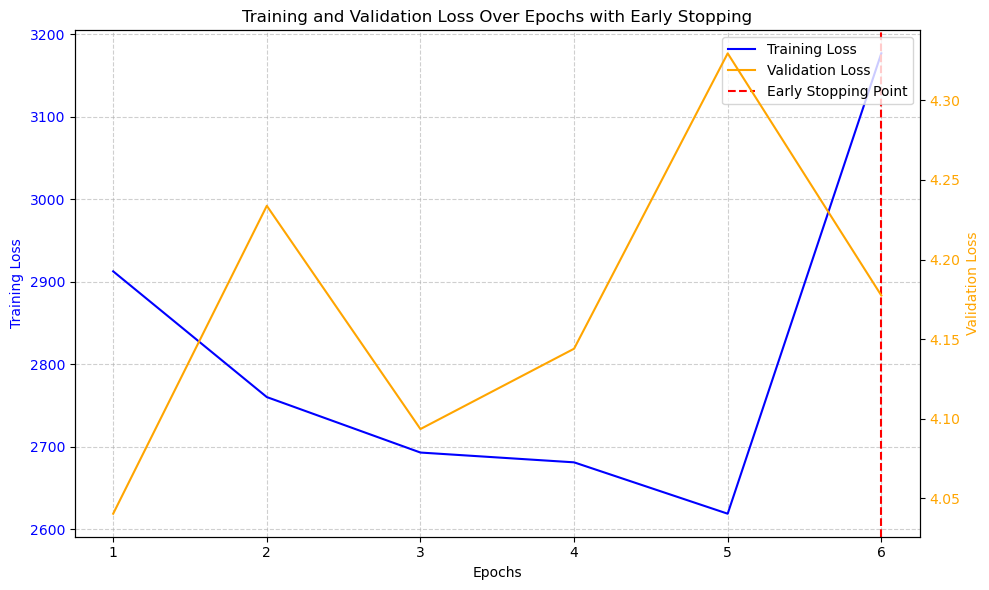

In [20]:
# Plot Training Loss
fig, ax1 = plt.subplots(figsize=(10, 6))
line1 = ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(visible=True, linestyle='--', alpha=0.6)

# Plot Validation Loss on a Secondary Y-Axis
ax2 = ax1.twinx()
line2 = ax2.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
ax2.set_ylabel('Validation Loss', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add Early Stopping Point
line3 = ax1.axvline(len(train_losses), color='r', linestyle='--', label='Early Stopping Point')

# Combine legends from both axes
lines = line1 + line2 + [line3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

# Add Title
plt.title('Training and Validation Loss Over Epochs with Early Stopping')
fig.tight_layout()
plt.savefig(f'plots/01_train_vall_loss/{file_name}.png')
plt.show()

# HyperOpt Feed Forward ANN

In [ ]:
def objective(params):
    # Extract hyperparameters
    n_layers = int(params['n_layers'])  # Convert to integer
    hidden_size = int(params['hidden_size'])  # Convert to integer
    dropout_rate = params['dropout_rate']
    lr = params['lr']
    batch_size = int(params['batch_size'])  # Convert to integer
    optimizer_name = params['optimizer']
    activation_name = params['activation']
    alpha = params['alpha']
    lambda_ = params['lambda']

    # Dynamically build the model
    class ANNModel(nn.Module):
        def __init__(self, input_dim):
            super(ANNModel, self).__init__()
            layers = []
            in_features = input_dim
            
            # Create hidden layers dynamically
            for _ in range(n_layers):
                layers.append(nn.Linear(in_features, hidden_size))
                if activation_name == "ReLU":
                    layers.append(nn.ReLU())
                elif activation_name == "LeakyReLU":
                    layers.append(nn.LeakyReLU())
                elif activation_name == "Tanh":
                    layers.append(nn.Tanh())
                layers.append(nn.Dropout(dropout_rate))
                in_features = hidden_size
            
            # Output layer
            layers.append(nn.Linear(hidden_size, 1))
            self.network = nn.Sequential(*layers)
        
        def forward(self, x):
            return self.network(x)
    
    # Initialize model, loss, and optimizer
    model = ANNModel(X_train.shape[1])
    criterion = nn.MSELoss()

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=alpha)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=alpha)
    elif optimizer_name == "RMSprop":
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=alpha)

    # DataLoader
    train_dataset = TensorDataset(X_train, y_train)
    validate_dataset = TensorDataset(X_validate, y_validate)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validate_loader = DataLoader(validate_dataset, batch_size=batch_size)

    # Training
    model.train()
    for epoch in range(5):  # Reduced epochs for faster tuning
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in validate_loader:
            val_predictions = model(X_val_batch)
            val_loss += criterion(val_predictions, y_val_batch.unsqueeze(1)).item()
    val_loss /= len(validate_loader)

    return {'loss': val_loss, 'status': STATUS_OK}

# Define the search space
search_space = {
    'n_layers': hp.quniform('n_layers', 2, 10, 1),
    'hidden_size': hp.quniform('hidden_size', 32, 256, 32),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'lr': hp.loguniform('lr', np.log(1e-4), np.log(1e-2)),
    'batch_size': hp.quniform('batch_size', 16, 128, 16),
    'optimizer': hp.choice('optimizer', ['Adam', 'SGD', 'RMSprop']),
    'activation': hp.choice('activation', ['ReLU', 'LeakyReLU', 'Tanh']),
    'alpha': hp.loguniform('alpha', np.log(1e-6), np.log(1e-1)),
    'lambda': hp.loguniform('lambda', np.log(1e-6), np.log(1e-1))
}

# Run HyperOpt
trials = Trials()
best_params = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

print("Best Parameters:", best_params)

In [ ]:
# Extract the best hyperparameters
best_n_layers = int(best_params['n_layers'])
best_hidden_size = int(best_params['hidden_size'])
best_dropout_rate = best_params['dropout_rate']
best_lr = best_params['lr']
best_batch_size = int(best_params['batch_size'])
best_optimizer_name = ['Adam', 'SGD', 'RMSprop'][best_params['optimizer']]  # Mapping choice index to value
best_activation_name = ['ReLU', 'LeakyReLU', 'Tanh'][best_params['activation']]
best_alpha = best_params['alpha']
best_lambda = best_params['lambda']

# Define the model with the best hyperparameters
class FinalANNModel(nn.Module):
    def __init__(self, input_dim):
        super(FinalANNModel, self).__init__()
        layers = []
        in_features = input_dim
        
        # Create hidden layers dynamically
        for _ in range(best_n_layers):
            layers.append(nn.Linear(in_features, best_hidden_size))
            if best_activation_name == "ReLU":
                layers.append(nn.ReLU())
            elif best_activation_name == "LeakyReLU":
                layers.append(nn.LeakyReLU())
            elif best_activation_name == "Tanh":
                layers.append(nn.Tanh())
            layers.append(nn.Dropout(best_dropout_rate))
            in_features = best_hidden_size
        
        # Output layer
        layers.append(nn.Linear(best_hidden_size, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Initialize the model
model = FinalANNModel(X_train.shape[1])

# Define loss function
criterion = nn.MSELoss()

# Define optimizer
if best_optimizer_name == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_alpha)
elif best_optimizer_name == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=best_lr, weight_decay=best_alpha)
elif best_optimizer_name == "RMSprop":
    optimizer = optim.RMSprop(model.parameters(), lr=best_lr, weight_decay=best_alpha)

# Create Dataset objects
train_dataset = TensorDataset(X_train, y_train)
validate_dataset = TensorDataset(X_validate, y_validate)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=best_batch_size)

# Train the model
epochs = 50  # Number of training epochs
train_losses = []
val_losses = []
early_stop = False
patience = 5
min_delta = 0.001
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    if early_stop:
        print("Early stopping triggered!")
        break

    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in validate_loader:
            val_predictions = model(X_val_batch)
            val_loss += criterion(val_predictions, y_val_batch.unsqueeze(1)).item()
    val_loss /= len(validate_loader)

    # Save losses for plotting
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)

    logging.info(f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            early_stop = True

# Evaluate the model on the test set and external validation set
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test).squeeze().numpy()
    y_external_pred = model(X_external).squeeze().numpy()

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)*100

external_mse = mean_squared_error(y_external, y_external_pred)
external_mae = mean_absolute_error(y_external, y_external_pred)
external_rmse = np.sqrt(external_mse)
external_r2 = r2_score(y_external, y_external_pred)*100

print(f"Test Set - MSE: {test_mse:.2f}, MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, R2: {test_r2:.2f}")
print(f"External Validation - MSE: {external_mse:.2f}, MAE: {external_mae:.2f}, RMSE: {external_rmse:.2f}, R2: {external_r2:.2f}")

In [ ]:
# Plot Training Loss
fig, ax1 = plt.subplots(figsize=(10, 6))  # Increase width for the subplots as well
line1 = ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(visible=True, linestyle='--', alpha=0.6)  # Add grid to the primary axis

# Plot Validation Loss on a Secondary Y-Axis
ax2 = ax1.twinx()
line2 = ax2.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
ax2.set_ylabel('Validation Loss', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add Early Stopping Point
line3 = ax1.axvline(len(train_losses), color='r', linestyle='--', label='Early Stopping Point')

# Combine legends from both axes
lines = line1 + line2 + [line3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

# Add Title
plt.title('Training and Validation Loss Over Epochs with Early Stopping')
fig.tight_layout()
plt.savefig(f'plots/01_train_vall_loss/{file_name}.png')
plt.show()

# Optuna HP
## Test field (include alpha and lambda)

In [ ]:
# Define objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    n_layers = trial.suggest_int("n_layers", 2, 10)  # Number of hidden layers
    hidden_size = trial.suggest_int("hidden_size", 32, 256, step=32)  # Neurons in hidden layers
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)  # Dropout probability
    learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)  # Learning rate
    batch_size = trial.suggest_int("batch_size", 16, 128, step=16)  # Batch size
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])  # Optimizer
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "Tanh"])  # Activation function
    alpha = trial.suggest_float("alpha", 1e-6, 1e-1, log=True)  # L2 regularization term
    lambda_ = trial.suggest_float("lambda", 1e-6, 1e-1, log=True)  # L1 regularization term

    # Define activation function
    activation = {
        "ReLU": nn.ReLU(),
        "LeakyReLU": nn.LeakyReLU(),
        "Tanh": nn.Tanh()
    }[activation_name]

    # Define the model
    class ANNModel(nn.Module):
        def __init__(self, input_dim):
            super(ANNModel, self).__init__()
            layers = []
            layers.append(nn.Linear(input_dim, hidden_size))
            layers.append(activation)
            layers.append(nn.Dropout(dropout_rate))

            for _ in range(n_layers - 1):
                layers.append(nn.Linear(hidden_size, hidden_size))
                layers.append(activation)
                layers.append(nn.Dropout(dropout_rate))

            layers.append(nn.Linear(hidden_size, 1))  # Output layer
            self.model = nn.Sequential(*layers)

        def forward(self, x):
            return self.model(x)

    # Prepare the model
    input_dim = X_train.shape[1]
    model = ANNModel(input_dim)

    # Select optimizer with weight decay (L2 regularization)
    optimizer = {
        "Adam": optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha),
        "SGD": optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=alpha),
        "RMSprop": optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=alpha)
    }[optimizer_name]

    # Add learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    criterion = nn.MSELoss()

    # Prepare DataLoader
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # Early stopping parameters
    patience = 5
    best_val_loss = float("inf")
    patience_counter = 0

    # Training loop
    model.train()
    for epoch in range(100):  # Max epochs
        epoch_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch.unsqueeze(1))
            # Add L1 regularization manually
            l1_loss = lambda_ * sum(p.abs().sum() for p in model.parameters())
            total_loss = loss + l1_loss
            total_loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_predictions = model(X_validate)
            val_loss = criterion(val_predictions, y_validate.view(-1, 1)).item()

        # Update the scheduler
        scheduler.step(val_loss)

        # Log the current learning rate
        current_lr = scheduler.optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}, Training Loss: {epoch_loss/len(train_loader):.4f}, "
              f"Validation Loss: {val_loss:.4f}, Learning Rate: {current_lr:.6f}")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return best_val_loss

# Run the hyperparameter optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

In [ ]:
# Best hyperparameters
print("Best hyperparameters:", study.best_params)

In [ ]:
# Visualize History results
optuna.visualization.plot_optimization_history(study)

In [ ]:
# Visualize Importance results
optuna.visualization.plot_param_importances(study)

In [ ]:
# Extract the best hyperparameters from the Optuna study
best_params = study.best_params
n_layers = best_params["n_layers"]
hidden_size = best_params["hidden_size"]
dropout_rate = best_params["dropout_rate"]
learning_rate = best_params["lr"]
batch_size = best_params["batch_size"]
optimizer_name = best_params["optimizer"]
activation_name = best_params["activation"]
alpha = best_params["alpha"]  # L2 regularization term
lambda_ = best_params["lambda"]  # L1 regularization term

# Define the activation function
activation = {
    "ReLU": nn.ReLU(),
    "LeakyReLU": nn.LeakyReLU(),
    "Tanh": nn.Tanh()
}[activation_name]

# Define the model using the best hyperparameters
class ANNModel(nn.Module):
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_size))
        layers.append(activation)
        layers.append(nn.Dropout(dropout_rate))

        for _ in range(n_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(activation)
            layers.append(nn.Dropout(dropout_rate))

        layers.append(nn.Linear(hidden_size, 1))  # Output layer
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Prepare the model
input_dim = X_train.shape[1]
model = ANNModel(input_dim)

# Select the optimizer with weight decay (L2 regularization)
optimizer = {
    "Adam": optim.Adam(model.parameters(), lr=learning_rate, weight_decay=alpha),
    "SGD": optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=alpha),
    "RMSprop": optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=alpha)
}[optimizer_name]

criterion = nn.MSELoss()

# Prepare DataLoader for training
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Training loop with L1 regularization
model.train()
for epoch in range(100):  # Number of epochs
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch.unsqueeze(1))
        
        # Add L1 regularization manually
        l1_loss = lambda_ * sum(p.abs().sum() for p in model.parameters())
        total_loss = loss + l1_loss
        
        total_loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    logging.info(f"Epoch {epoch+1}, Training Loss: {epoch_loss/len(train_loader):.4f}")

In [ ]:
# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Early stopping parameters
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float("inf")  # Initialize to a very large value
patience_counter = 0  # Counter for epochs without improvement

# Prepare Validation DataLoader
validate_data = TensorDataset(X_validate, y_validate)
validate_loader = DataLoader(validate_data, batch_size=batch_size)

# Training Loop
epochs = 100
train_losses = []
val_losses = []

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(message)s")

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    
    # Training phase
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch.unsqueeze(1))
        
        # Add L1 regularization manually
        l1_loss = lambda_ * sum(p.abs().sum() for p in model.parameters())
        total_loss = loss + l1_loss
        
        total_loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val_batch, y_val_batch in validate_loader:
            val_predictions = model(X_val_batch)
            val_loss += criterion(val_predictions, y_val_batch.unsqueeze(1)).item()
    val_loss /= len(validate_loader)

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Logging
    train_losses.append(epoch_loss / len(train_loader))
    val_losses.append(val_loss)
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    logging.info(
        f"Epoch {epoch+1}/{epochs}, Training Loss: {epoch_loss / len(train_loader):.4f}, "
        f"Validation Loss: {val_loss:.4f}, Learning Rate: {current_lr:.6f}"
    )

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        best_model_path = f"models/{file_name}.pth"
        torch.save(model.state_dict(), best_model_path)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            logging.info("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(torch.load(best_model_path))
logging.info("Training complete. Best model loaded.")

In [ ]:
# Plot Training Loss
fig, ax1 = plt.subplots(figsize=(10, 6))  # Increase width for the subplots as well
line1 = ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='b')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(visible=True, linestyle='--', alpha=0.6)  # Add grid to the primary axis

# Plot Validation Loss on a Secondary Y-Axis
ax2 = ax1.twinx()
line2 = ax2.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
ax2.set_ylabel('Validation Loss', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add Early Stopping Point
line3 = ax1.axvline(len(train_losses), color='r', linestyle='--', label='Early Stopping Point')

# Combine legends from both axes
lines = line1 + line2 + [line3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

# Add Title
plt.title('Training and Validation Loss Over Epochs with Early Stopping')
fig.tight_layout()
plt.savefig(f'plots/01_train_vall_loss/{file_name}.png')
plt.show()

# Ray HP

In [ ]:
def train_ann(config, checkpoint_dir=None):
    # Extract hyperparameters
    n_layers = config["n_layers"]
    hidden_size = config["hidden_size"]
    dropout_rate = config["dropout_rate"]
    lr = config["lr"]
    batch_size = config["batch_size"]
    activation_name = config["activation"]
    max_epochs = 50  # You can configure this



# Store large objects in the Ray object store
X_train_ref = ray.put(X_train)
y_train_ref = ray.put(y_train)
X_validate_ref = ray.put(X_validate)
y_validate_ref = ray.put(y_validate)

def train_ann(config, checkpoint_dir=None):
    # Retrieve objects from the Ray object store
    X_train = ray.get(X_train_ref)
    y_train = ray.get(y_train_ref)
    X_validate = ray.get(X_validate_ref)
    y_validate = ray.get(y_validate_ref)
    
    # Extract hyperparameters
    n_layers = config["n_layers"]
    hidden_size = config["hidden_size"]
    dropout_rate = config["dropout_rate"]
    lr = config["lr"]
    batch_size = config["batch_size"]
    activation_name = config["activation"]
    max_epochs = config["max_epochs"] 

    # Define the model
    class ANNModel(nn.Module):
        def __init__(self, input_dim):
            super(ANNModel, self).__init__()
            layers = []
            in_features = input_dim
            for _ in range(n_layers):
                layers.append(nn.Linear(in_features, hidden_size))
                if activation_name == "ReLU":
                    layers.append(nn.ReLU())
                elif activation_name == "LeakyReLU":
                    layers.append(nn.LeakyReLU())
                elif activation_name == "Tanh":
                    layers.append(nn.Tanh())
                layers.append(nn.Dropout(dropout_rate))
                in_features = hidden_size
            layers.append(nn.Linear(hidden_size, 1))  # Output layer
            self.network = nn.Sequential(*layers)

        def forward(self, x):
            return self.network(x)

    # Initialize model, loss function, and optimizer
    model = ANNModel(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Create DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    validate_dataset = TensorDataset(X_validate, y_validate)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validate_loader = DataLoader(validate_dataset, batch_size=batch_size)

    # Early stopping parameters
    best_val_loss = float("inf")
    patience = 2
    counter = 0

    # Training Loop
    for epoch in range(max_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val_batch, y_val_batch in validate_loader:
                val_predictions = model(X_val_batch)
                val_loss += criterion(val_predictions, y_val_batch.unsqueeze(1)).item()
        val_loss /= len(validate_loader)

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            logging.info(f"Early stopping triggered at epoch {epoch + 1}")
            break

        # Print progress for debugging (optional)
        logging.info(f"Epoch {epoch + 1}/{max_epochs}, Validation Loss: {val_loss:.4f}")

    # Report metrics to Ray Tune
    session.report({"val_loss": val_loss})

In [ ]:
search_space = {
    "n_layers": tune.randint(2, 10),
    "hidden_size": tune.randint(32, 256),
    "dropout_rate": tune.uniform(0.1, 0.5),
    "lr": tune.loguniform(1e-4, 1e-2),
    "batch_size": tune.choice([16, 32, 64, 128]),
    "activation": tune.choice(["ReLU", "LeakyReLU", "Tanh"]),
    "max_epochs": tune.choice([10, 20, 50])  # Dynamically choose epochs
}

In [ ]:
# Set up the scheduler
scheduler = ASHAScheduler(
    metric="val_loss",  # Metric to optimize
    mode="min",         # We aim to minimize the validation loss
    max_t=50,           # Max number of epochs
    grace_period=5,     # Minimum number of epochs before stopping
    reduction_factor=2  # Halve trials that perform poorly
)

# Set up the search algorithm
search_algo = HyperOptSearch(
    metric="val_loss",
    mode="min"
)

# Use an absolute path for storage_path
absolute_storage_path = os.path.abspath("ray_results")

def trial_dirname_creator(trial):
    # Shorten trial directory names by removing the full parameter list
    return f"trial_{trial.trial_id}"

analysis = tune.run(
    train_ann,                    # Training function
    config=search_space,          # Hyperparameter search space
    scheduler=scheduler,          # Scheduler for pruning bad trials
    search_alg=search_algo,       # Search algorithm
    num_samples=10,               # Number of trials to run
    resources_per_trial={"cpu": 3, "gpu": 0},  # Resource allocation per trial
    max_concurrent_trials=2,  # Allow only 2 trials to run concurrently
    storage_path=absolute_storage_path,       # Use absolute path
    trial_dirname_creator=trial_dirname_creator,  # Shorten trial names
)

# Print the best hyperparameters
best_config = analysis.get_best_config(metric="val_loss", mode="min")
print("Best Hyperparameters:", best_config)

# Test & External Validation Evaluation

In [21]:
# Test and external validation
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test).squeeze().numpy()
    y_external_pred = model(X_external).squeeze().numpy()

test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)*100

external_mse = mean_squared_error(y_external, y_external_pred)
external_mae = mean_absolute_error(y_external, y_external_pred)
external_rmse = np.sqrt(external_mse)
external_r2 = r2_score(y_external, y_external_pred)*100

print(f"Test Set - MSE: {test_mse:.2f}, MAE: {test_mae:.2f}, RMSE: {test_rmse:.2f}, R2: {test_r2:.2f}")
print(f"External Validation - MSE: {external_mse:.2f}, MAE: {external_mae:.2f}, RMSE: {external_rmse:.2f}, R2: {external_r2:.2f}")

Test Set - MSE: 3.52, MAE: 1.31, RMSE: 1.88, R2: 30.26
External Validation - MSE: 5.97, MAE: 1.59, RMSE: 2.44, R2: -24.59


Test Set MSE: 3.5221
Test Set MAE: 1.3120
Test Set RMSE: 1.8767
Test Set R2: 30.2581
Test Set MSLE: 0.1690


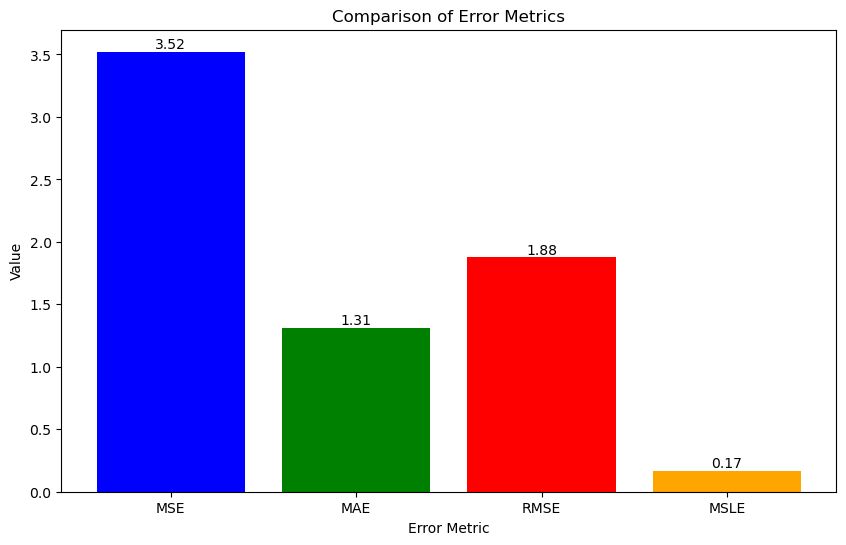

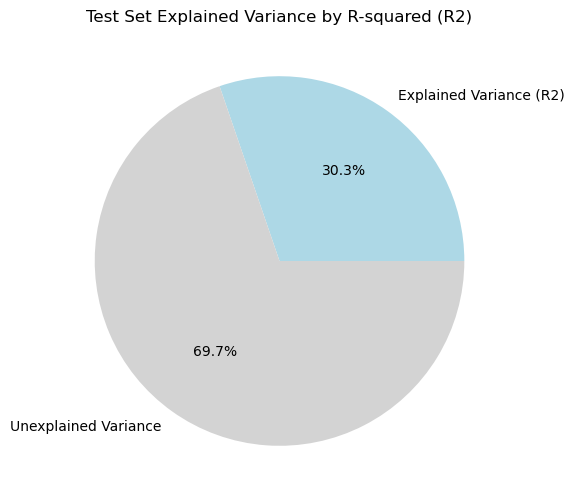

In [22]:
# Metrics calculation
mse = mean_squared_error(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred) * 100

print(f"Test Set MSE: {mse:.4f}")
print(f"Test Set MAE: {mae:.4f}")
print(f"Test Set RMSE: {rmse:.4f}")
print(f"Test Set R2: {r2:.4f}")

# Initialize error metrics
error_metrics = ['MSE', 'MAE', 'RMSE']
values = [mse, mae, rmse]

# Try to calculate MSLE
try:
    msle = mean_squared_log_error(y_test, y_test_pred)
    print(f"Test Set MSLE: {msle:.4f}")
    
    # Add MSLE to the list of metrics if applicable
    error_metrics.append('MSLE')
    values.append(msle)
except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

# Plot error metrics (with or without MSLE)
plt.figure(figsize=(10, 6))
bars = plt.bar(error_metrics, values, color=['blue', 'green', 'red', 'orange'][:len(error_metrics)])
plt.xlabel('Error Metric')
plt.ylabel('Value')
plt.title('Comparison of Error Metrics')

# Annotate values on top of the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.savefig(f'plots/03_metrics/{file_name}_internal.png')
plt.show()

# Plotting R-squared (R2) for the test set
plt.figure(figsize=(6, 6))

if r2 >= 0:
    plt.pie([r2, 100 - r2], 
            labels=['Explained Variance (R2)', 'Unexplained Variance'], 
            colors=['lightblue', 'lightgrey'], autopct='%1.1f%%')
else:
    plt.pie([100], labels=['Unexplained Variance'], colors=['lightgrey'], autopct='%1.1f%%')

plt.title('Test Set Explained Variance by R-squared (R2)')
plt.savefig(f'plots/03_metrics/{file_name}_internal_R2.png')
plt.show()


External Validation Set MSE: 5.9688
External Validation Set MAE: 1.5866
External Validation Set RMSE: 2.4431
External Validation Set R2: -24.5899
Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.


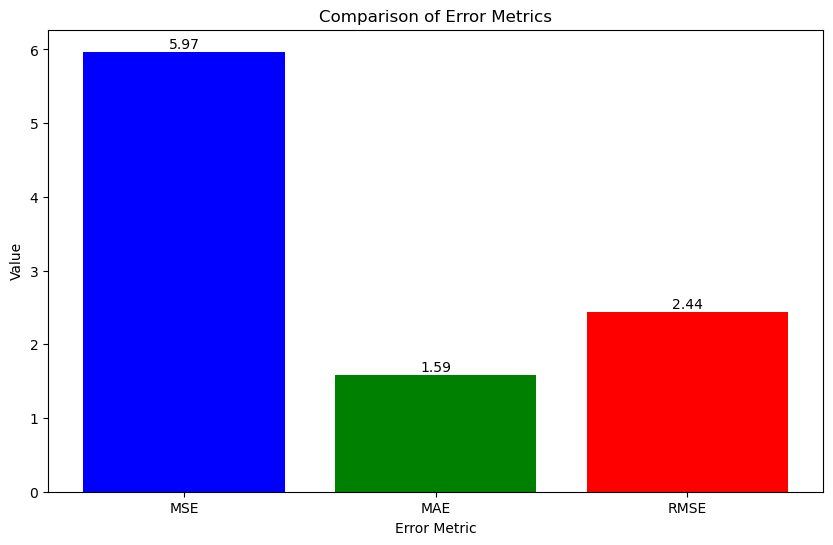

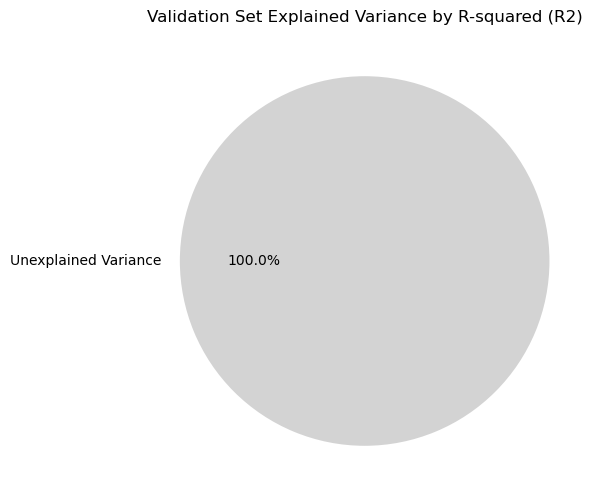

In [23]:
# Metrics for external validation set
mse_external = mean_squared_error(y_external, y_external_pred)
mae_external = mean_absolute_error(y_external, y_external_pred)
rmse_external = np.sqrt(mse_external)
r2_external = r2_score(y_external, y_external_pred) * 100

print(f"External Validation Set MSE: {mse_external:.4f}")
print(f"External Validation Set MAE: {mae_external:.4f}")
print(f"External Validation Set RMSE: {rmse_external:.4f}")
print(f"External Validation Set R2: {r2_external:.4f}")

# Initialize error metrics
error_metrics = ['MSE', 'MAE', 'RMSE']
values = [mse_external, mae_external, rmse_external]

# Try to calculate MSLE
try:
    msle_external = mean_squared_log_error(y_external, y_external_pred)
    print(f"External Validation Set MSLE: {msle_external:.4f}")
    
    # Add MSLE to the list of metrics if applicable
    error_metrics.append('MSLE')
    values.append(msle_external)
except ValueError:
    print("Mean Squared Logarithmic Error cannot be calculated because targets contain negative values.")

# Plot error metrics (with or without MSLE)
plt.figure(figsize=(10, 6))
bars = plt.bar(error_metrics, values, color=['blue', 'green', 'red', 'orange'][:len(error_metrics)])
plt.xlabel('Error Metric')
plt.ylabel('Value')
plt.title('Comparison of Error Metrics')

# Annotate values on top of the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', 
             ha='center', va='bottom', fontsize=10)

plt.savefig(f'plots/03_metrics/{file_name}_external.png')
plt.show()

# Plotting R-squared (R2) for the external validation set
plt.figure(figsize=(6, 6))

if r2_external >= 0:
    plt.pie([r2_external, 100 - r2_external], 
            labels=['Explained Variance (R2)', 'Unexplained Variance'], 
            colors=['lightblue', 'lightgrey'], autopct='%1.1f%%')
else:
    plt.pie([100], labels=['Unexplained Variance'], colors=['lightgrey'], autopct='%1.1f%%')

plt.title('Validation Set Explained Variance by R-squared (R2)')
plt.savefig(f'plots/03_metrics/{file_name}_external_R2.png')
plt.show()


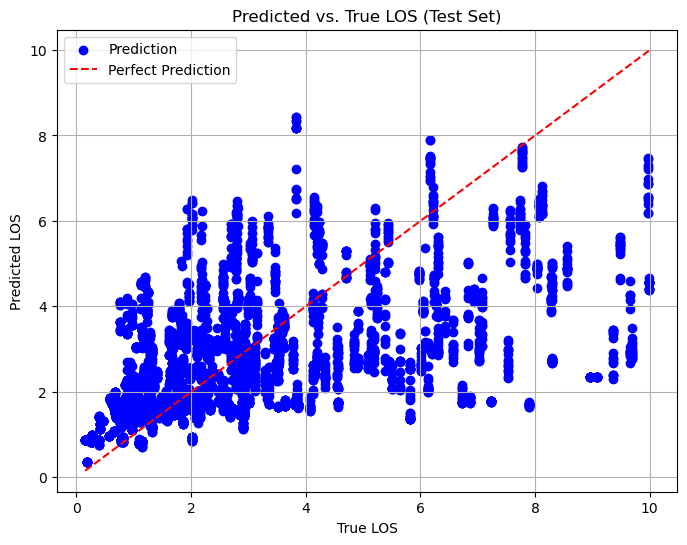

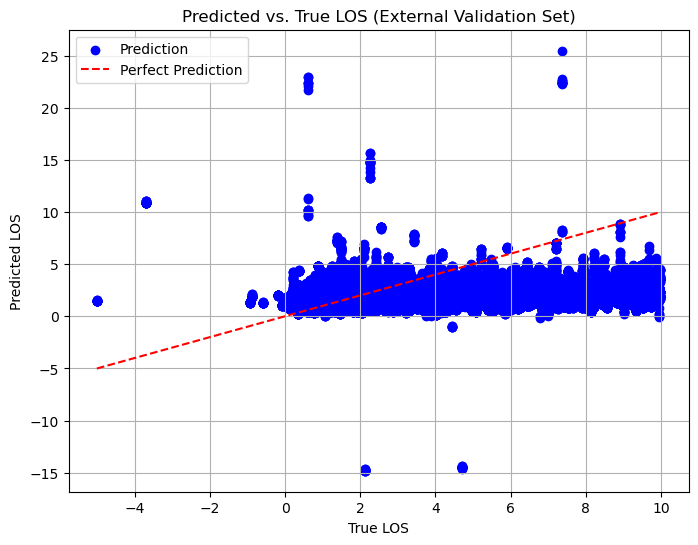

In [24]:
# Test Set Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Prediction')

# Line for Perfect Prediction
perfect_line = np.linspace(y_test.min(), y_test.max(), 100)
plt.plot(perfect_line, perfect_line, color='red', linestyle='--', label='Perfect Prediction')

# Labels, legend, and grid
plt.xlabel('True LOS')
plt.ylabel('Predicted LOS')
plt.legend()
plt.grid(True)
plt.title('Predicted vs. True LOS (Test Set)')

# Save the plot as a PNG image
plt.savefig(f"plots/02_prediction_plot/02_true_vs_pred/{file_name}_test_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# External Validation Set Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_external, y_external_pred, color='blue', label='Prediction')

# Line for Perfect Prediction (y = x)
perfect_line_ext = np.linspace(y_external.min(), y_external.max(), 100)
plt.plot(perfect_line_ext, perfect_line_ext, color='red', linestyle='--', label='Perfect Prediction')

# Labels, legend, and grid
plt.xlabel('True LOS')
plt.ylabel('Predicted LOS')
plt.legend()
plt.grid(True)
plt.title('Predicted vs. True LOS (External Validation Set)')

# Save the plot as a PNG image
plt.savefig(f"plots/02_prediction_plot/02_true_vs_pred/{file_name}_external_plot.png", dpi=300, bbox_inches='tight')
plt.show()

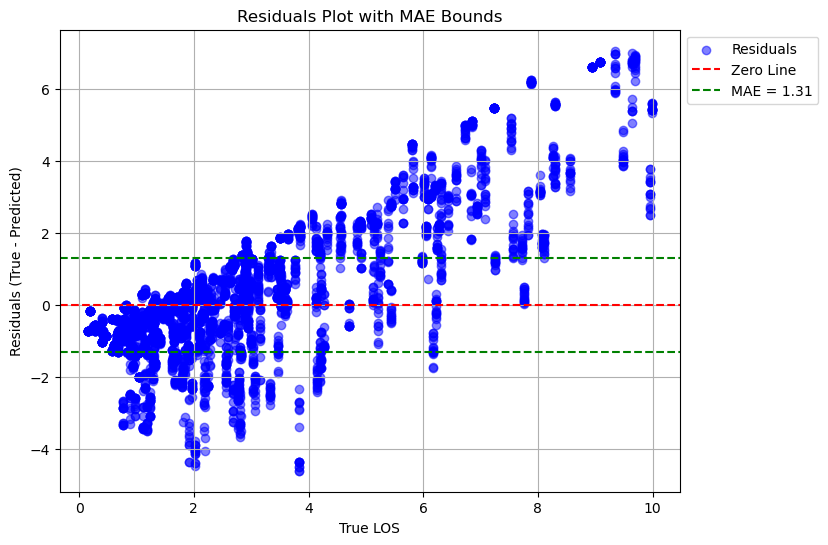

In [26]:
# Convert y_test to a 1D numpy array
#y_test = y_test.numpy().flatten()


# Calculate residuals
residuals = y_test - y_test_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuals, color='blue', alpha=0.5, label="Residuals")
plt.axhline(y=0, color='red', linestyle='--', label="Zero Line")
plt.axhline(y=mae, color='green', linestyle='--', label=f"MAE = {mae:.2f}")
plt.axhline(y=-mae, color='green', linestyle='--')
plt.xlabel('True LOS')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residuals Plot with MAE Bounds')
plt.grid(True)

# Place the legend outside of the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Save the plot as a PNG image
plt.savefig(f"plots/02_Prediction_Plot/01_residuals/{file_name}_residuals_plot.png", dpi=300, bbox_inches='tight')
plt.show()

# Save model

In [ ]:
torch.save(model.state_dict(), f"models/{file_name}.pth")

# Load model

In [ ]:
# Define file
subfolder = "o01_feed_forward.pth"

# Reinitialize the model architecture
input_dim = X_test.shape[1]  # Ensure this matches the original input dimension
model = ANNModel(input_dim)

# Load the saved model state
model.load_state_dict(torch.load(f"models/{subfolder}"))
model.eval()  # Set the model to evaluation mode

"""
After that I must run the block with layers.
Be careful, the layers must be exaclty the same. 
"""